# Open Street Map Data Case Study
By Rachel Foong

**Map Area:** Singapore
Chosen mainly due to its friendly size. One of the smallest countries I could think of and it's close to the country of my origin - Singapore.

**Data Sources:**
- OpenStreetMap Relation: https://www.openstreetmap.org/relation/536780#map=9/1.3218/104.0687
- Metro Extract: https://mapzen.com/data/metro-extracts/metro/singapore/

### Data Overview

In [1]:
#declare all variables
import sqlite3
import pprint, os

folder_PATH="data_input_output"
file_PATH=folder_PATH+"/singapore.db"

In [2]:
#Function to display readable filesize
def GetHumanReadable(size,precision=2):
    suffixes=[' B',' KB',' MB',' GB',' TB']
    suffixIndex = 0
    while size > 1024 and suffixIndex < 4:
        suffixIndex += 1 #increment the index of the suffix
        size = size/1024.0 #apply the division
    return "%.*f%s"%(precision,size,suffixes[suffixIndex])

theFiles = list(os.listdir(folder_PATH))

#Calculate size for all files here. 
theDict = dict()
for something in theFiles: 
    try:
        new_path = folder_PATH+"\\"+something
        theStats = os.stat(new_path)
        theDict[something] = theStats
    except Exception as e:
        print(e)

#Display list of files and filesize
print("File Names and Sizes", "\n++++++++++++++++++++++++")
for item in theDict:
    print("{:30s} {:s}".format(item,GetHumanReadable(theDict[item].st_size)))

File Names and Sizes 
++++++++++++++++++++++++
nodes.csv                      118.59 MB
nodes_tags.csv                 4.90 MB
sample.osm                     9.24 MB
singapore.db                   255.52 MB
singapore.osm                  328.98 MB
ways.csv                       13.55 MB
ways_nodes.csv                 43.46 MB
ways_tags.csv                  21.44 MB


- Number of nodes: 1,517,456
- Number of ways: 237,891
- Number of unique users: 2,178

In [3]:
#Enquire database
db = sqlite3.connect(file_PATH)
c = db.cursor()
c.execute("SELECT e.user, COUNT(*) as num FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e GROUP BY e.user ORDER BY num DESC LIMIT 10;")
rows = c.fetchall()

#Print results
print("Top 10 contributing users", "\n++++++++++++++++++++++++")
pprint.pprint(rows)

Top 10 contributing users 
++++++++++++++++++++++++
[('JaLooNz', 404899),
 ('berjaya', 117377),
 ('rene78', 77581),
 ('cboothroyd', 72204),
 ('lmum', 51342),
 ('kingrollo', 39063),
 ('Luis36995', 38821),
 ('ridixcr', 38239),
 ('Sihabul Milah', 37160),
 ('calfarome', 32945)]


### Problems Encountered with Data

#### Cultural issues
- Language Inconsistency - some were in English, others in Chinese
- Street names were a mixture of Malay and English e.g. *Jalan* is Malay for road. I've included a list of other Malay names into the expected list of words during the audit process in the Python File https://github.com/redewe/udacity/blob/master/python%20files/XML%20file%20to%20CSV%20files.ipynb


#### User entry issues
- Alternative keys for the same value were discovered e.g. name_1, name_2, building_1 Full list as below taken from the Python file mentioned above
- Some of the keys were also tagged as "FIXME" which meant that the data was incomplete
- While there was a tag for address, the keys like *Jalan* which is Malay for road was also used as a tag on its own

#### Map boundary issues
- More than 50% of points includes places outside the country boundary of Singapore

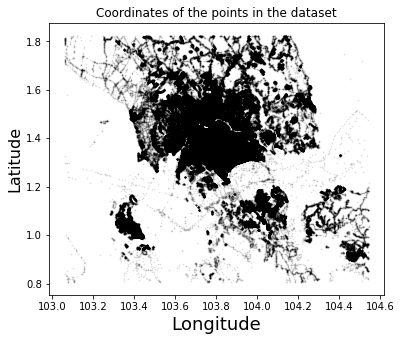

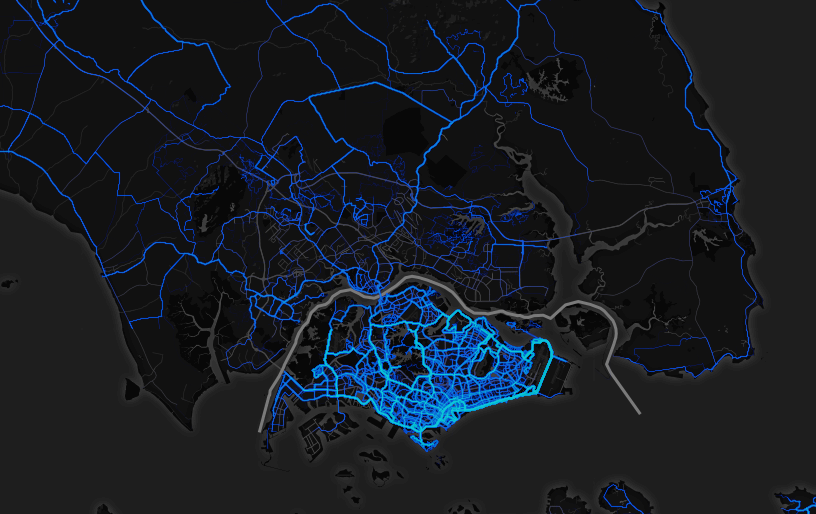

In [27]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#Find nodes where they are beyond singapore's borders using https://gps-coordinates.org/singapore-latitude.php
c.execute("SELECT lat As Latitude, lon as Longitude FROM nodes;")

party = DataFrame(c.fetchall())
party.columns = map(lambda x: x[0], c.description)

#names = list(map(lambda x: x[0], c.description))

#Code taken from https://www.kaggle.com/somesnm/new-york-parties-eda 
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

#fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax = plt.scatter(party['Longitude'].values, party['Latitude'].values,
              color='black', s=0.5, label='train', alpha=0.1)
ax.axes.set_title('Coordinates of the points in the dataset')
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=16)
ax.figure.set_size_inches(6,5)
#plt.ylim(city_lat_border)
#plt.xlim(city_long_border)
plt.show()

#taken from http://labs.strava.com/heatmap/#10/103.51044/1.55232/blue/bike
print("Map of Singapore for comparison - boundary is grey line")
Image("singaporeheatmap.PNG")


## Other ideas about the dataset

- To improve the dataset, it's best if the OSM data automatically filters for points outside the boundaries of any given country/city. As proven above, it's problematic for many when trying to validate the data. 

- While the OSM data may be useful for those who would like to look beyond just Singapore in mapping routes, the data can be in a supplementary file than combined into the main file. 


In [28]:
db.close()